In [37]:
import io
import pandas as pd
import numpy as np
import scipy as sci

from sklearn.preprocessing import MinMaxScaler # found in the scikit-learn package
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import SGD
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [38]:
# The path where the CSV file is located
# Use your own path
path = "vegetable-korma-curry-sales.csv"
# Read the CSV file and store it as a pandas DataFrame
df = pd.read_csv(path)
df = df['Sales']

df.index = df.index + 1 #Initialize the index at 1

# Lag the data frame
data = pd.concat([df.shift(1), df.shift(2), df.shift(3), df], axis=1)
data.columns = ['x1','x2', 'x3', 'y']
data = data.iloc[4:,]
data.head()

,x1,x2,x3,y
5,190.0,206.0,240.0,228
6,228.0,190.0,206.0,235
7,235.0,228.0,190.0,208
8,208.0,235.0,228.0,229
9,229.0,208.0,235.0,259


In [39]:
# Pick 80% of the data but keeps the original sequence (R)
train = data[:int(data.shape[0]*0.8)]
test = data[int(data.shape[0]*0.8):]

# Clean data in case of missing data
data = data.dropna()
train = train.dropna()
test = test.dropna()

In [40]:
ytrain_min = float(train.min()['y'])
ytrain_max = float(train.max()['y'])
ytrain_range = ytrain_max - ytrain_min

ytest_min = float(test.min()['y'])
ytest_max = float(test.max()['y'])
ytest_range = ytest_max - ytest_min
print (ytest_range)

201.0


In [41]:
def scale(data):
    scaled_data = data.copy()
    for column in data.columns: 
      scaled_data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    return scaled_data

In [42]:
def scale_back(data, data_min, data_range):
    data_ = data.copy()
    data_.head()
    for column in data_.columns: 
        data_[column] = (data_range) * data_[column] + data_min
    return data_

In [43]:
train_ = scale(train)
test_ = scale(test)
test_

,x1,x2,x3,y
2921,0.353234,0.303483,0.532338,0.373134
2922,0.373134,0.353234,0.303483,0.572139
2923,0.572139,0.373134,0.353234,0.492537
2924,0.492537,0.572139,0.373134,0.606965
2925,0.606965,0.492537,0.572139,0.253731
...,...,...,...,...
3646,0.572139,0.393035,0.363184,0.333333
3647,0.333333,0.572139,0.393035,0.567164
3648,0.567164,0.333333,0.572139,0.452736
3649,0.452736,0.567164,0.333333,0.522388


In [44]:

n = train_.columns                                    #column labels
xtrain = train_.filter(items = ['x1','x2','x3'])  #input of the training set
ytrain = train_.filter(items = ['y'])                    #output of the training set

xtest = test_.filter(items = ['x1','x2','x3'])  #input of the test set
ytest = test_.filter(items = ['y'])                    #output of the test set

ytest.head()

,y
2921,0.373134
2922,0.572139
2923,0.492537
2924,0.606965
2925,0.253731


In [45]:
# Train a neural network model
# https://www.tensorflow.org/api_docs/python/tf/keras/activations
model = Sequential()

# First add a layer with 3 neurons for 3 input variables (3 lags)
# and the RELU activation function
model.add(Dense(3, input_dim=3, activation='relu'))

# Then add a hidden layer with 8 neurons
# and the sigmoid activation function
model.add(Dense(8, activation='sigmoid'))

# Then add the output layer with 1 neuron
# and the RELU activation function
model.add(Dense(1, activation='relu'))
model.build((None, 3))
model.summary()
print(model.count_params())

opt = Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=opt, metrics=['mean_squared_error'])
model.fit(x=xtrain,y=ytrain, epochs=500, verbose=0)
print(model.weights)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________
53
[<tf.Variable 'dense_6/kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[ 0.99315745,  0.24470896,  0.50431323],
       [-0.10452676,  0.6920108 ,  0.53629655],
       [-0.2930911 ,  1.1037048 ,  0.55231893]], dtype=float32)>, <tf.Variable 'dense_6/bias:0' shape=(3,) dtype=float32, numpy=array([ 0.22365779, -0.00650184, -0.13082504], dtype=float32)>, <tf.Variable 'dense_7/kernel:

In [46]:
# Use the model to calculate predictions for the train set
y_pred = model.predict(xtrain)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns =['y'] 

In [47]:
y_pred_rescaled = scale_back(pd.DataFrame(y_pred), ytrain_min, ytrain_range)
y_pred_rescaled.columns =['y'] 
y_train_rescaled = scale_back(pd.DataFrame(ytrain), ytrain_min, ytrain_range)
y_train_rescaled.head()

,y
5,228.0
6,235.0
7,208.0
8,229.0
9,259.0


In [48]:
# r-squared
r2_squared = r2_score(y_train_rescaled, y_pred_rescaled)
print('R-squared score of the train set:', round(r2_squared,4))

# mean squared error
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print('Root mean squared error of the train set:', round(rmse,4))

# AIC
# trainable_weights includes neuron weights and biases
param_num = model.count_params()
print("Total number of parameters: ", param_num)
aic = train.shape[0] * np.log(mse) + 2*param_num
print("Akaike Information Criterion:", round(aic, 4))

R-squared score of the train set: 0.2371
Root mean squared error of the train set: 25.5511
Total number of parameters:  53
Akaike Information Criterion: 19005.6534


In [49]:
y_pred = model.predict(xtest)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns =['y'] 
y_pred_df.head()

,y
0,0.366396
1,0.336645
2,0.404275
3,0.412713
4,0.465397


In [50]:
y_pred_rescaled = scale_back(pd.DataFrame(y_pred), ytest_min, ytest_range)
y_pred_rescaled.columns =['y'] 
y_test_rescaled = scale_back(pd.DataFrame(ytest), ytest_min, ytest_range)
y_test_rescaled.head()

,y
2921,212.0
2922,252.0
2923,236.0
2924,259.0
2925,188.0


In [51]:
# r-squared with test set
r2_squared = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score of the test set:', round(r2_squared,4))

# mean squared error with the test set
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print('Root mean squared error of the test set:', round(rmse,4))

R-squared score of the test set: 0.1554
Root mean squared error of the test set: 26.4287


Text(0.5, 1.0, 'Scatter plot of predicted vs actual data')

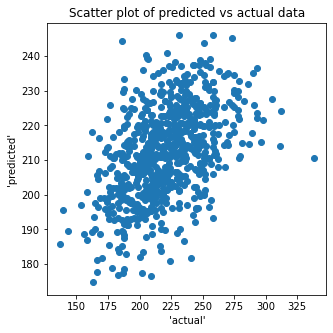

In [52]:
# Generate a scatter plot of predicted vs actual data
plt.figure(figsize=(5,5))
plt.scatter(x = y_test_rescaled, y = y_pred_rescaled)
plt.xlabel("'actual'")
plt.ylabel("'predicted'")
plt.title("Scatter plot of predicted vs actual data")

In [53]:
y_test_rescaled['time'] = y_test_rescaled.index
y_test_rescaled = y_test_rescaled.sort_values(by=['time'])
y_actual = pd.DataFrame(y_test_rescaled['y'])
y_actual.reset_index(drop=True, inplace=True)

y_pred_rescaled['time'] = y_test_rescaled.index
y_pred_rescaled = y_pred_rescaled.sort_values(by=['time'])
y_hat = pd.DataFrame(y_pred_rescaled['y'])
y_hat.reset_index(drop=True, inplace=True)

time = y_test_rescaled['time']

# To export the predictions and test values to a CSV file
df.to_csv(r'Prediction-vegetable-korma-curry.csv', index = False)
y_test_rescaled.to_csv(r'ytest.csv', index = False)
y_pred_rescaled.to_csv(r'yhat.csv', index = False)

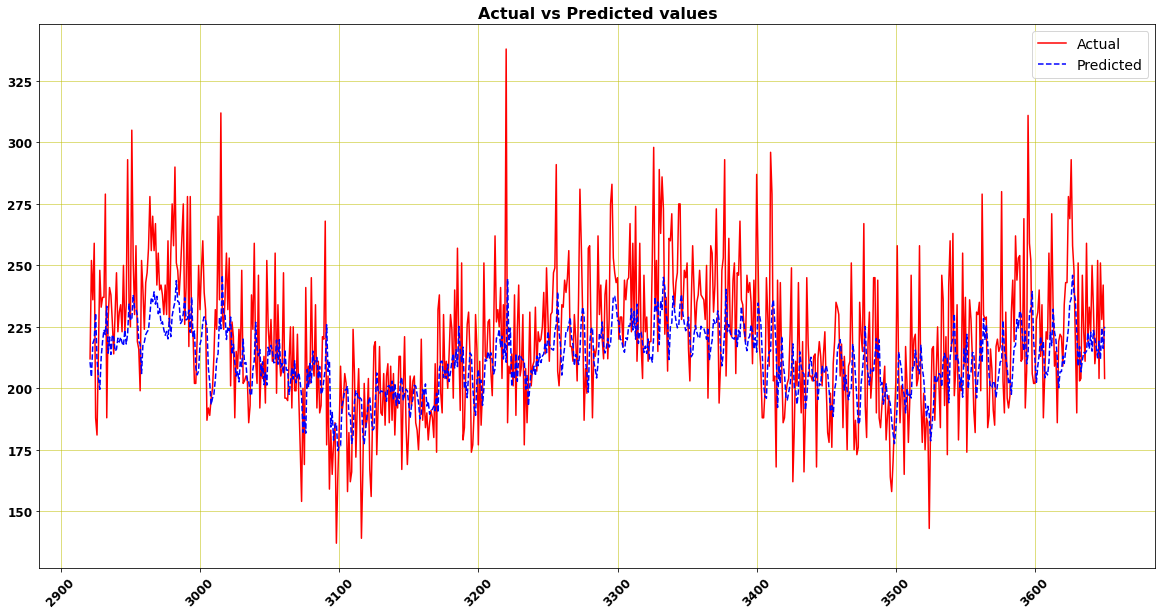

In [54]:
plt.figure(figsize=(20, 10))
plt.plot(time, y_actual, linestyle='solid', color='r')
plt.plot(time, y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('Actual vs Predicted values', weight='bold', fontsize=16)
#plt.ylabel('demand', weight='bold', fontsize=14)
#plt.xlabel('time', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()